In [ ]:
# pip install ultralytics supervision pandas scikit-learn scikit-image matplotlib seaborn pymupdf pytesseract

## Data Preprocesing

In [4]:
import pandas
import fitz
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
from pathlib import Path
import pytesseract


pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

### Converting provided PDFs to images

In [6]:
from data_utils import pdf_to_images

pdf_to_images('data/1_raw/books/book1.pdf', 'data/2_splitted/book1')
pdf_to_images('data/1_raw/books/book2.pdf', 'data/2_splitted/book2')
pdf_to_images('data/1_raw/books/book3.pdf', 'data/2_splitted/book3')
pdf_to_images('data/1_raw/books/book4.pdf', 'data/2_splitted/book4')
pdf_to_images('data/1_raw/books/book5.pdf', 'data/2_splitted/book5')
pdf_to_images('data/1_raw/books/book6.pdf', 'data/2_splitted/book6')
pdf_to_images('data/1_raw/books/book7.pdf', 'data/2_splitted/book7')
pdf_to_images('data/1_raw/books/book8.pdf', 'data/2_splitted/book8')

Processing complete! Saved 31 images in 'data/2_splitted/book1'.
Processing complete! Saved 31 images in 'data/2_splitted/book2'.
Processing complete! Saved 16 images in 'data/2_splitted/book3'.
Processing complete! Saved 6 images in 'data/2_splitted/book4'.
Processing complete! Saved 11 images in 'data/2_splitted/book5'.
Processing complete! Saved 9 images in 'data/2_splitted/book6'.
Processing complete! Saved 9 images in 'data/2_splitted/book7'.
Processing complete! Saved 11 images in 'data/2_splitted/book8'.


### preprocessing images

In [11]:
from data_utils import (load_image, correct_skew, normalize_image, ensure_300ppi)

def transform_images( image_path, output_path=None):
    results = {}

    image = load_image(image_path)
    results['original'] = image.copy()

    deskewed = correct_skew(image)
    results['deskewed'] = deskewed.copy()
    
    normalized = normalize_image(deskewed)
    results['normalized'] = normalized.copy()
    
    scaled = ensure_300ppi(normalized)
    results['scaled'] = scaled.copy()

    return results


def process_books(input_dir, output_dir, transform_images):
    """Process all book images and save transformed versions."""

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through each book directory
    for book in os.listdir(input_dir):
        book_path = os.path.join(input_dir, book)

        # Skip if not a directory
        if not os.path.isdir(book_path):
            continue

        print(f"Processing book: {book}")

        # Process each image in the book
        for image_name in os.listdir(book_path):
            # Skip non-image files
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Extract page number from filename
            page_number = image_name.split('.')[0]
            image_path = os.path.join(book_path, image_name)

            # Define output path
            output_image_path = os.path.join(output_dir, f"{book}_{page_number}.png")

            try:
                # Apply transformation
                transformed_result = transform_images(image_path)
                final_image = transformed_result['normalized']

                # Save transformed image (convert RGB to BGR for OpenCV)
                cv2.imwrite(output_image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print(f"  Error processing {image_name}: {str(e)}")
                

# Run the processing function
input_dir = "data/2_splitted"
output_dir = "data/3_transformed"

process_books(input_dir, output_dir, transform_images)

Processing book: book1
Processing book: book2
Processing book: book3
Processing book: book4
Processing book: book5
Processing book: book6
Processing book: book7
Processing book: book8


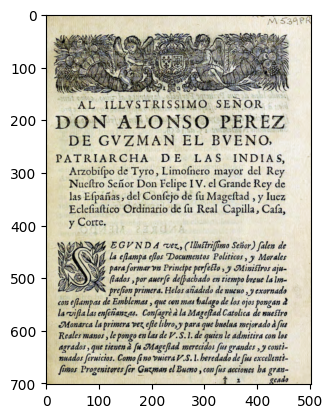

In [12]:
img = load_image('data/3_transformed/book6_1.png')
plt.imshow(img)

### Resizing and padding to a fixed size

In [ ]:
from PIL import Image
import os
from data_utils import resize_and_pad

target_height, target_width = 1024,1024 
for image in os.listdir("data/3_transformed"):
    img = Image.open(f"data/3_transformed/{image}")
    processed_img = resize_and_pad(img, target_height, target_width, output_dir="data/4_final")

## Mask Generation

In [7]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import os
from tqdm import tqdm

def generate_text_mask_with_tesseract(image_path):

    # Load the image
    image = cv2.imread(image_path)

    # Create a blank mask with the specified dimensions
    mask = np.zeros((1024, 768), dtype=np.uint8)

    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    paragraphs = pytesseract.image_to_boxes(gray, config='--psm 3')
    for b in paragraphs.splitlines():
        b = b.split()
        if len(b) == 6:  # Standard box format
            x1, y1, x2, y2 = int(b[1]), int(b[2]), int(b[3]), int(b[4])

            y1 = 1024 - y1
            y2 = 1024 - y2
            # Swap if needed
            y1, y2 = min(y1, y2), max(y1, y2)

            cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

    return mask

def process_dataset(image_folder, output_folder):

    os.makedirs(output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_folder, img_file)

        try:
            mask = generate_text_mask_with_tesseract(img_path)

            # Save mask
            mask_filename = os.path.splitext(img_file)[0] + '_mask.png'
            mask_path = os.path.join(output_folder, mask_filename)
            cv2.imwrite(mask_path, mask)

        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")



In [8]:
process_dataset("data/4_final", "data/masks")

Processing images: 100%|██████████| 124/124 [01:00<00:00,  2.04it/s]


## Model Building